In [38]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")


In [39]:
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchTool
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper

# Configure DuckDuckGo search wrapper
search = DuckDuckGoSearchAPIWrapper(
    max_results=3  # Set maximum number of results to return
)
# Define the tools your agent will use
tools = [DuckDuckGoSearchTool(api_wrapper=search)]

In [83]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

# Pull the executor prompt from LangChain Hub
prompt = hub.pull("wfh/react-agent-executor")
agent_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful assistant"
    ),
    ("placeholder", "{messages}"),
])

# Initialize the LLM
llm = ChatOpenAI(model="gpt-4o")

# Create the agent executor
agent_executor = create_react_agent(llm, tools, state_modifier=agent_prompt)

/Users/aniruddhachattopadhyay/Documents/Code/.venv/lib/python3.12/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [84]:
import operator
from typing import Annotated, List, Tuple, TypedDict

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [85]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

class Plan(BaseModel):
    """Plan to follow in future"""
    steps: List[str] = Field(
        description="Different steps to follow, should be in sorted order"
    )

# Define the planner prompt
planner_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps."""
    ),
    ("placeholder", "{messages}"),
])

# Initialize the planner
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

# Example planning invocation
plan = planner.invoke({
    "messages": [("user", "what is the hometown of the current Australia Open winner?")]
})

print(plan)

steps=['Identify the current year.', 'Determine the winner of the Australian Open for the current year.', 'Research the hometown of the identified winner.']


In [86]:
from typing import Union

class Response(BaseModel):
    """Response to user."""
    response: str

class Act(BaseModel):
    """Action to perform."""
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. \
If you need to further use tools to get the answer, use Plan."
    )

# Define the replanner prompt
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the following steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)

# Initialize the replanner
replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

In [87]:
from typing import Literal

async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}

You are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke({
        "messages": [("user", task_formatted)]
    })
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }

async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}

async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}

def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [88]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the planner node
workflow.add_node("planner", plan_step)

# Add the execution node
workflow.add_node("agent", execute_step)

# Add the replanner node
workflow.add_node("replan", replan_step)

# Define the edges between nodes
workflow.add_edge(START, "planner")          # Start with planning
workflow.add_edge("planner", "agent")        # Then execute
workflow.add_edge("agent", "replan")         # Then replanning

# Conditional transition: decide whether to end or continue
workflow.add_conditional_edges(
    "replan",
    should_end,
)

# Compile the workflow into a runnable LangChain app
app = workflow.compile()

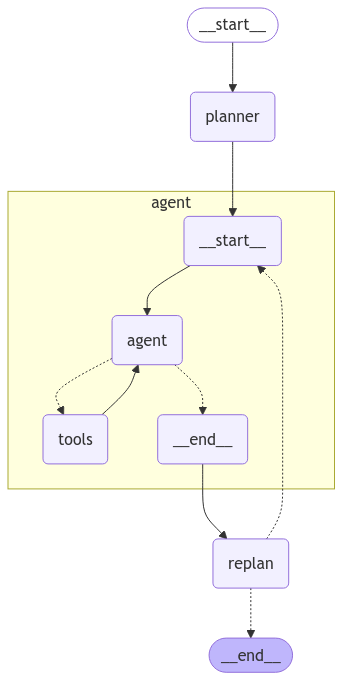

In [89]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [90]:
from maxim.logger.components.generation import GenerationConfig, GenerationError
from maxim.logger.components.retrieval import RetrievalConfig
from maxim.logger.components.trace import Trace, TraceConfig
from maxim.logger.components.session import Session, SessionConfig
from maxim.logger.components.span import Span, SpanConfig
from maxim.logger.logger import Logger, LoggerConfig
from uuid import uuid4
from dotenv import load_dotenv
import tiktoken
from time import sleep, time
load_dotenv()

True

In [91]:
base_url = "https://app.getmaxim.ai"
maxim_api_key = os.environ["MAXIM_API_KEY"]
log_repository_id = os.environ["LOG_REPO_ID"]

# Set up logger
logger_config = LoggerConfig(id=log_repository_id)
logger = Logger(config=logger_config, api_key=maxim_api_key, base_url=base_url)

# Set up session
sessionId = str(uuid4())
session_config = SessionConfig(id=sessionId)
session = logger.session(session_config)

In [92]:
def callPlannerGeneration(user_input,plan,span):
    system_prompt = planner_prompt.messages[0].prompt.template
    generationConfig = GenerationConfig(id=str(uuid4()), name="generation", provider="openai", model="gpt-4o", model_parameters={"temperature": 0}, messages=[{"role":"system", "content":system_prompt},{"role":"user", "content": user_input}])
    generation = span.generation(generationConfig)
    enc = tiktoken.get_encoding("o200k_base")
    llm_output = str(plan)
    messages = generationConfig.messages
    messages_string = ''.join(["role: " + entry["role"] + " content: " + entry['content'] for entry in messages])
    prompt_tokens = len(enc.encode(messages_string))
    completion_tokens = len(enc.encode(llm_output))
    generation.result({
                "id": generation.id,
                "object": "text_completion",
                "created": int(time()),
                "model": generationConfig.model,
                "choices": [
                    {
                        "index": 0,
                        "text": llm_output,
                        "logprobs": None,
                        "finish_reason": "stop",
                    },
                ],
                "usage": {
                    "prompt_tokens": prompt_tokens,
                    "completion_tokens": completion_tokens,
                    "total_tokens": prompt_tokens+completion_tokens,
                },
            })
    generation.end()

In [93]:
def callReplanGeneration(user_input,past_steps,plan,span):
    system_prompt = replanner_prompt.messages[0].prompt.template
    system_prompt = system_prompt.format(input=user_input,plan=plan,past_steps=past_steps)
    generationConfig = GenerationConfig(id=str(uuid4()), name="generation", provider="openai", model="gpt-4o", model_parameters={"temperature": 0}, messages=[{"role":"system", "content":system_prompt},{"role":"user", "content": user_input}])
    generation = span.generation(generationConfig)
    enc = tiktoken.get_encoding("o200k_base")
    llm_output = str(plan)
    messages = generationConfig.messages
    messages_string = ''.join(["role: " + entry["role"] + " content: " + entry['content'] for entry in messages])
    prompt_tokens = len(enc.encode(messages_string))
    completion_tokens = len(enc.encode(llm_output))
    generation.result({
                "id": generation.id,
                "object": "text_completion",
                "created": int(time()),
                "model": generationConfig.model,
                "choices": [
                    {
                        "index": 0,
                        "text": llm_output,
                        "logprobs": None,
                        "finish_reason": "stop",
                    },
                ],
                "usage": {
                    "prompt_tokens": prompt_tokens,
                    "completion_tokens": completion_tokens,
                    "total_tokens": prompt_tokens+completion_tokens,
                },
            })
    generation.end()

In [94]:
def callFinalGeneration(user_input,past_steps,response,trace):
    system_prompt = replanner_prompt.messages[0].prompt.template
    system_prompt = system_prompt.format(input=user_input,plan=plan,past_steps=past_steps)
    generationConfig = GenerationConfig(id=str(uuid4()), name="generation", provider="openai", model="gpt-4o", model_parameters={"temperature": 0}, messages=[{"role":"system", "content":system_prompt},{"role":"user", "content": user_input}])
    generation = trace.generation(generationConfig)
    enc = tiktoken.get_encoding("o200k_base")
    llm_output = str(response)
    messages = generationConfig.messages
    messages_string = ''.join(["role: " + entry["role"] + " content: " + entry['content'] for entry in messages])
    prompt_tokens = len(enc.encode(messages_string))
    completion_tokens = len(enc.encode(llm_output))
    generation.result({
                "id": generation.id,
                "object": "text_completion",
                "created": int(time()),
                "model": generationConfig.model,
                "choices": [
                    {
                        "index": 0,
                        "text": llm_output,
                        "logprobs": None,
                        "finish_reason": "stop",
                    },
                ],
                "usage": {
                    "prompt_tokens": prompt_tokens,
                    "completion_tokens": completion_tokens,
                    "total_tokens": prompt_tokens+completion_tokens,
                },
            })
    generation.end()

In [97]:
config = {"recursion_limit": 50}
inputs = {"input": "Give the name of captain and which team they play for, for current year's champions league winning team"}
response = ''
past_steps = None
# Set up trace
traceId = str(uuid4())
trace_config = TraceConfig(id=traceId)
trace = session.trace(trace_config)
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(f"{k}:{v}")
            print('*'*50)
            if k == 'planner':
                span = trace.span(SpanConfig(id=str(uuid4()), name=f"Agent {k}"))
                callPlannerGeneration(inputs['input'],v['plan'],span)
                span.end()
            if k == 'replan':
                if 'response' in v:
                    callFinalGeneration(inputs['input'],past_steps,v['response'],trace)
                else:
                    span = trace.span(SpanConfig(id=str(uuid4()), name=f"Agent {k}"))
                    callReplanGeneration(inputs['input'],past_steps,v['plan'],span)
                    span.end()
            if k == 'agent':
                sleep(1)
                past_steps = v['past_steps']
trace.end()       

planner:{'plan': ['Identify the current year, which is 2023.', 'Research the winner of the 2023 UEFA Champions League.', 'Find out the captain of the winning team of the 2023 UEFA Champions League.', 'Find out which team the captain plays for.', 'Provide the name of the captain and the team they play for.']}
**************************************************
agent:{'past_steps': [('Identify the current year, which is 2023.', 'The current year is 2023.')]}
**************************************************
replan:{'plan': ['Research the winner of the 2023 UEFA Champions League.', 'Find out the captain of the winning team of the 2023 UEFA Champions League.', 'Provide the name of the captain and the team they play for.']}
**************************************************
agent:{'past_steps': [('Research the winner of the 2023 UEFA Champions League.', 'The winner of the 2023 UEFA Champions League was Real Madrid, who defeated Borussia Dortmund 2-0 in the final.')]}
***********************